# Analysis flow velocity dataset

## Case 3: Flow velocity of the river Thames

![stationImage.jpg](https://nrfaapps.ceh.ac.uk/nrfa/image/nrfaImage/stationImage.jpg?id=NRFA_D007232&category=H490L)

*A photo from near the measuring station at Kingston, taken from [here](https://nrfa.ceh.ac.uk/data/station/gallery/39001). Photo of station 39001 from the National River Flow Archive (UK Centre for Ecology & Hydrology). All rights reserved unless stated otherwise.*

**What is the propagated uncertainty? *How fast does the river Thames flow at Kingston?***

In this project, you have chosen to work on the uncertainty of water depths ($h$ [m]) and flow rate ($q$ [m³/s]) of a river. You have observations every 15 minutes from a station at the river Thames at Kingston, UK, over one month. The data has been taken from the Department for Environment
Food & Rural Affairs' Data Services platform [here](https://environment.data.gov.uk/flood-monitoring/id/stations/3400TH). Remember that the discharge can be computed as

$$
q = u S
$$

where $u$ [m/s] is the flow velocity and $S$ [m²] is the cross-sectional area of the flow. The cross-sectional area, simplified to a rectangle, can be computed as $S = h*w$ , where $w$ [m] is the width of the river at the measuring station. Here, we have already corrected for the datum of the the water depths $h$, so the values in the dataset are relative to river bed. For simplicity, we can  at the station.

Thus, assuming a discharge width of $w=100$ m, we can simplify the previous equation as

$$
\begin{aligned}
q &= u \cdot w \cdot h  \\
u &= \frac{q}{w \cdot h}  \\
u &= \frac{q}{95 \cdot h}  \\
\end{aligned}
$$

**The goal of this project is:**
1. Choose a reasonable distribution function for $q$ and $h$.
2. Fit the chosen distributions to the observations of $q$ and $h$.
3. Assuming $q$ and $h$ are independent, propagate their distributions to obtain the distribution of $u$.
4. Analyze the distribution of $u$.

## Importing packages

In [1]:
import numpy as np              # For math
import matplotlib.pyplot as plt # For plotting
from scipy import stats         # For math
from math import ceil, trunc    # For plotting

# This is just cosmetic - it updates the font size for our plots
plt.rcParams.update({'font.size': 14})

## 1. Explore the data

The first step in the analysis is exploring the data, visually and through statistics. 

Tip: In the workshop files, you have used the pandas `.describe()` function to obtain the statistics of a data vector. `scipy.stats` has a similar function.

In [2]:
import os
from urllib.request import urlretrieve

def findfile(fname):
    if not os.path.isfile(fname):
        print(f"Downloading {fname}...")
        urlretrieve('https://github.com/TUDelft-MUDE/source-files/raw/main/file/GA1.4/'+fname, fname)

findfile('dataset_thames.csv')

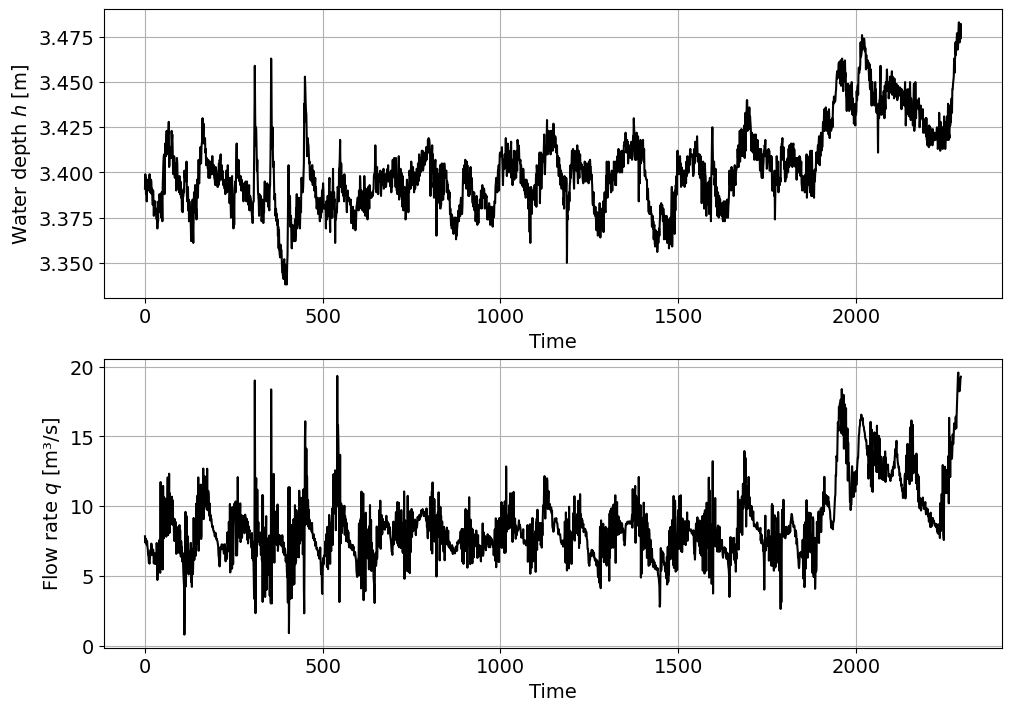

In [3]:
# Import the data from the .csv file
h, q = np.genfromtxt('dataset_thames.csv', delimiter=",", unpack=True, skip_header=True)

# Plot the time series for the water depth
fig, ax = plt.subplots(2, 1, figsize=(10, 7), layout = 'constrained')
ax[0].plot(h,'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Water depth $h$ [m]')
ax[0].grid()

# Plot the time series for the flow rate
ax[1].plot(q,'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Flow rate $q$ [m³/s]')
ax[1].grid()

In [4]:
# Statistics for h
print(stats.describe(h))

DescribeResult(nobs=np.int64(2296), minmax=(np.float64(3.338), np.float64(3.4829999999999997)), mean=np.float64(3.4024294425087103), variance=np.float64(0.0005394276992097655), skewness=np.float64(0.6919650519228886), kurtosis=np.float64(0.5856673438073909))


In [5]:
# Statistics for q
print(stats.describe(q))

DescribeResult(nobs=np.int64(2296), minmax=(np.float64(0.784), np.float64(19.58)), mean=np.float64(8.656878048780488), variance=np.float64(6.718419145905734), skewness=np.float64(1.145316818123934), kurtosis=np.float64(2.015523354162916))


<div style="background-color:#AABAB2; color: black; width:90%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 1:</b>

Describe the data based on the previous statistics:
- Which variable features a higher variability? Also consider the magnitudes of the different variables.
- What does the skewness coefficient represent? Which kind of distribution functions should we consider to fit based on this coefficient?
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>

- $h$ and $q$ have a similar mean, but $h$ has significantly lower variance. To compare the variability of variables with different magnitudes, it can be useful to compute the <b>coefficient of variation</b>, which normalizes the standard deviation against the mean. If we do so, we obtain $CV(h)=\sigma/\mu=\sqrt{0.000539}/3.402 = 0.007$ and $CV(q)=\sigma/\mu= \sqrt{6.718}/8.657 = 0.299$. Thus, $q$ has significantly higher variability than $h$.
- Both $h$ and $q$ have a positive non-zero skewness, with the one for $q$ being significantly higher. Thus, the data presents a right tail and mode < median < mean. An appropriate distribution for $h$ and $q$ would be one which: (1) it is bounded in 0 (no negative values of $h$ or $q$ are physically possible), and (2) has a positive tail. If we consider the distributions that you have been introduced to, Lognormal, Gumbel or Exponential distributions would be a possibility.
</div>

## 2. Empirical distribution functions

Now, we are going to compute and plot the empirical PDF and CDF for each variable. Note that you have the pseudo-code for the empirical CDF in the [reader](https://mude.citg.tudelft.nl/book/2025/univariate_distributions/empirical.html).

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 2:</b>  
 
Define a function to compute the empirical CDF. Plot your empirical PDF and CDF.
</p>
</div>

In [6]:
def ecdf(observations):
    """Write a function that returns [non_exceedance_probabilities, sorted_values]."""
    sorted_values = np.sort(observations)
    n = sorted_values.size
    non_exceedance_probabilities = np.arange(1, n+1) / (n + 1)
    return [non_exceedance_probabilities, sorted_values]

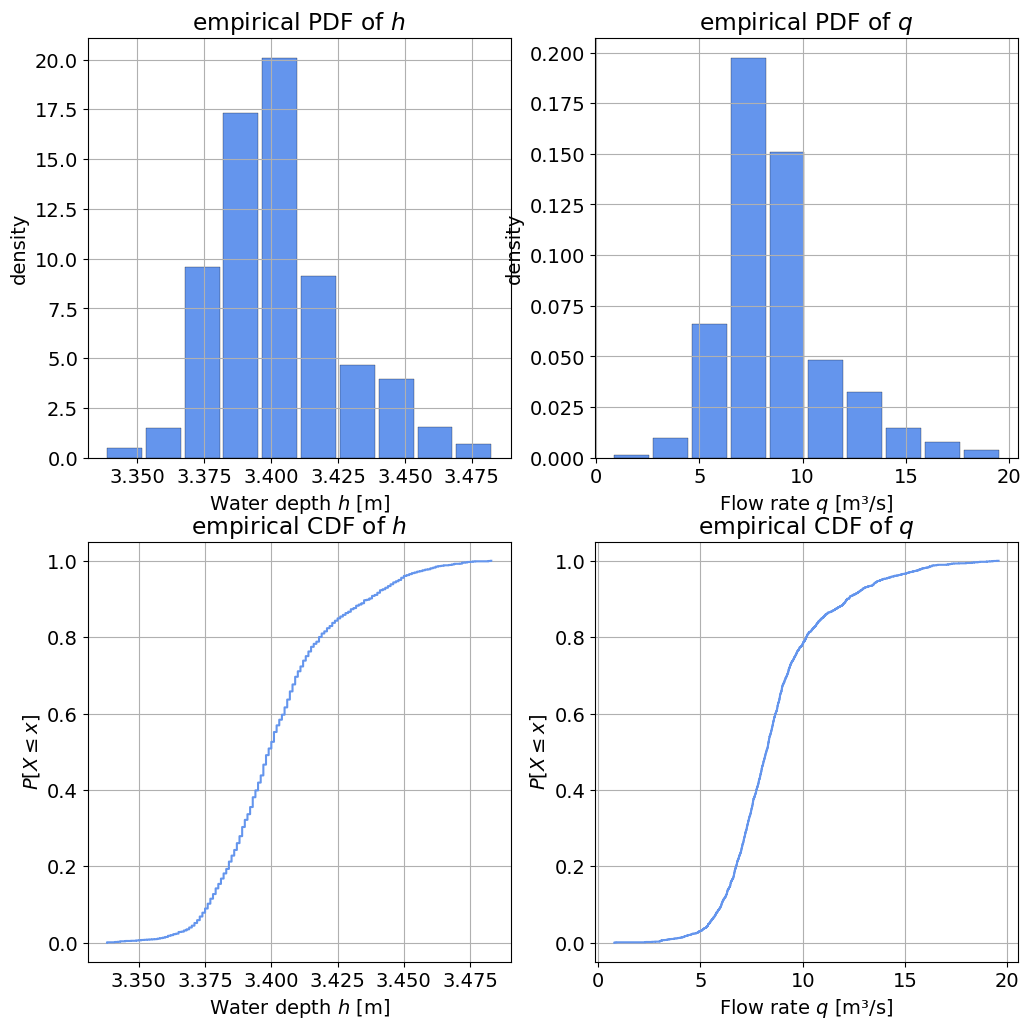

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Plot the PDF of h
axes[0,0].hist(h, edgecolor='k', linewidth=0.2, rwidth = 0.9, color='cornflowerblue', density = True, bins = 10)
axes[0,0].set_xlabel('Water depth $h$ [m]')
axes[0,0].set_ylabel('density')
axes[0,0].set_title('empirical PDF of $h$')
axes[0,0].grid()

# Plot the PDF of q
axes[0,1].hist(q, edgecolor='k', linewidth=0.2, rwidth = 0.9,color='cornflowerblue', density = True, bins = 10)
axes[0,1].set_xlabel('Flow rate $q$ [m³/s]')
axes[0,1].set_ylabel('density')
axes[0,1].set_title('empirical PDF of $q$')
axes[0,1].grid()

# Plot the empirical CDF of h
axes[1,0].step(ecdf(h)[1], ecdf(h)[0], color='cornflowerblue')
axes[1,0].set_xlabel('Water depth $h$ [m]')
axes[1,0].set_ylabel(r'${P[X \leq x]}$')
axes[1,0].set_title('empirical CDF of $h$')
axes[1,0].grid()

# Plot the empirical CDF of q
axes[1,1].step(ecdf(q)[1], ecdf(q)[0], color='cornflowerblue')
axes[1,1].set_xlabel('Flow rate $q$ [m³/s]')
axes[1,1].set_ylabel(r'${P[X \leq x]}$')
axes[1,1].set_title('empirical CDF of $q$')
axes[1,1].grid()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 3:</b>   

Based on the results of Task 1 and the empirical PDF and CDF, select <b>one</b> distribution to fit to each variable. 
- For $h$, select between a Uniform or lognormal distribution.
- For $q$ choose between a Gaussian or Gumbel distribution.

</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>

$h$: Lognormal - Reasoning: This distribution is clearly not uniform, and the positive skewness suggests we need a right-tailed distribution.

$q$: Gumbel - Reasoning: This distribution has a clear right tail, so a symmetric distribution like the Gaussian is not an option. Be aware that both the Gaussian and Gumbel distributions are unbounded, which may enter permit impossible negative values.
</div>

## 3. Fitting a distribution

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 4:</b>  
 
Fit the selected distributions to the observations using MLE (Maximum Likelihood Estimation).
</p>
</div>

Hint: Use [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html)'s built-in functions (be careful with the parameter definitions!).

In [8]:
params_h = stats.lognorm.fit(h)
params_q = stats.gumbel_r.fit(q)

## 4. Assessing goodness of fit

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 5:</b>  
 
Assess the goodness of fit of the selected distribution using:
- One graphical method: QQplot or Logscale. Choose one.
- The Kolmogorov-Smirnov test.
</p>
</div>

Hint: The Kolmogorov-Smirnov test is implemented in [Scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

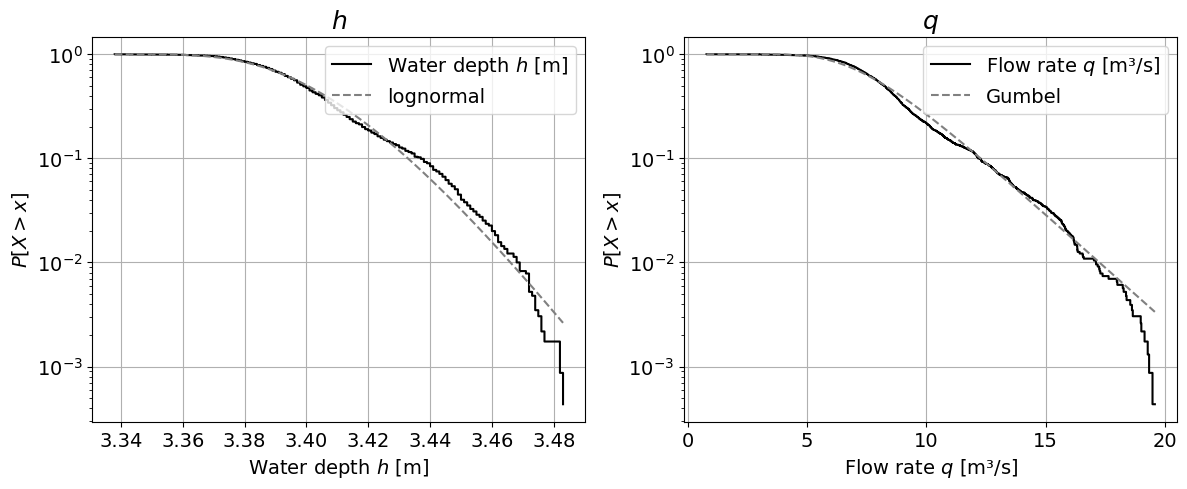

In [9]:
# Graphical method

# Logscale
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].step(ecdf(h)[1], 1-ecdf(h)[0], color='k', label='Water depth $h$ [m]')
axes[0].plot(ecdf(h)[1], 1-stats.lognorm.cdf(ecdf(h)[1], *params_h), '--', color = 'grey', label='lognormal')
axes[0].set_xlabel('Water depth $h$ [m]')
axes[0].set_ylabel('${P[X > x]}$')
axes[0].set_title('$h$', fontsize=18)
axes[0].set_yscale('log')
axes[0].legend(loc = "upper right")
axes[0].grid()

axes[1].step(ecdf(q)[1], 1-ecdf(q)[0], color='k', label='Flow rate $q$ [m³/s]')
axes[1].plot(ecdf(q)[1], 1-stats.gumbel_r.cdf(ecdf(q)[1], *params_q), '--', color = 'grey', label='Gumbel')
axes[1].set_xlabel('Flow rate $q$ [m³/s]')
axes[1].set_ylabel('${P[X > x]}$')
axes[1].set_title('$q$', fontsize=18)
axes[1].set_yscale('log')
axes[1].legend(loc = "upper right")
axes[1].grid()

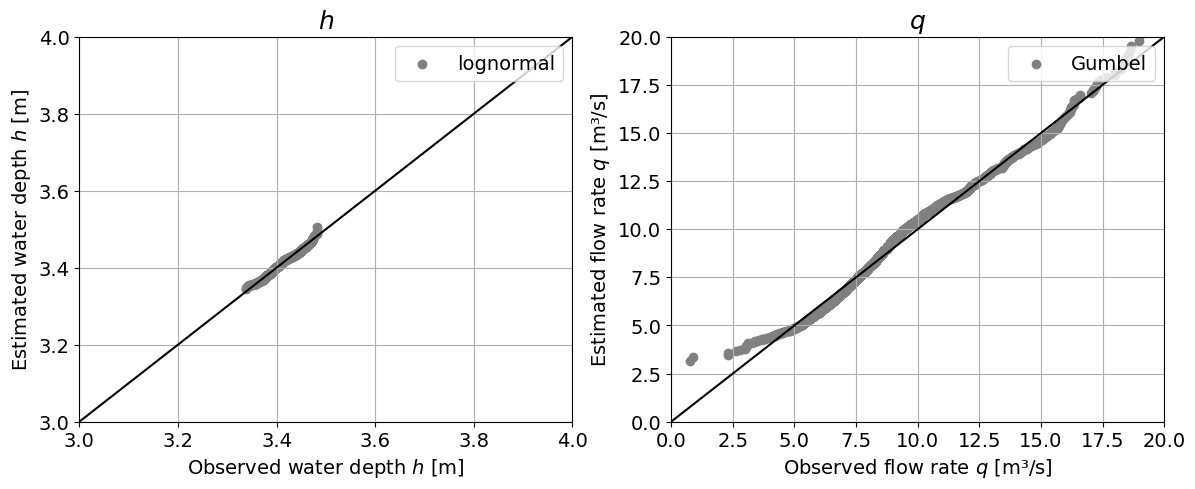

In [10]:
# QQ plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot([trunc(min(h)), ceil(max(h))], [trunc(min(h)), ceil(max(h))], 'k')
axes[0].scatter(ecdf(h)[1], stats.lognorm.ppf(ecdf(h)[0], *params_h), color='grey', label='lognormal')
axes[0].set_xlabel('Observed water depth $h$ [m]')
axes[0].set_ylabel('Estimated water depth $h$ [m]')
axes[0].set_title('$h$', fontsize=18)
axes[0].set_xlim([trunc(min(h)), ceil(max(h))])
axes[0].set_ylim([trunc(min(h)), ceil(max(h))])
axes[0].legend(loc = "upper right")
axes[0].grid()

axes[1].plot([trunc(min(q)), ceil(max(q))], [trunc(min(q)), ceil(max(q))], 'k')
axes[1].scatter(ecdf(q)[1], stats.gumbel_r.ppf(ecdf(q)[0], *params_q), color='grey', label='Gumbel')
axes[1].set_xlabel('Observed flow rate $q$ [m³/s]')
axes[1].set_ylabel('Estimated flow rate $q$ [m³/s]')
axes[1].set_title('$q$', fontsize=18)
axes[1].set_xlim([trunc(min(q)), ceil(max(q))])
axes[1].set_ylim([trunc(min(q)), ceil(max(q))])
axes[1].legend(loc = "upper right")
axes[1].grid()

In [11]:
# KS test
_, p_h = stats.kstest(h,stats.lognorm.cdf, args=params_h)
_, p_q = stats.kstest(q,stats.gumbel_r.cdf, args=params_q)

print('The p-value for the fitted lognormal distribution to h is:', round(p_h, 3))
print('The p-value for the fitted Gumbel distribution to q is:', round(p_q, 3))

The p-value for the fitted lognormal distribution to h is: 0.0
The p-value for the fitted Gumbel distribution to q is: 0.0


<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 6:</b>  
 
Interpret the results of the GOF techniques. How does the selected parametric distribution perform?
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>
    
- <b>Logscale plot</b>: This technique allows to visually assess the fitting of the parametric distribution to the tail of the empirical distribution. For $h$ and $q$, the lognormal and Gumbel distribution does not agree with the empirical distribution in the right tail very well. In both cases, high values start to slightly deviate from the empirical distribution, indicating that for lower non-exceedance probabilities it might not be a good fit.
- <b>QQ plot</b>: Similar conclusions to those for Logscale can be derived. Here, we can also see that both distributions deviate slightly in the left tail, too.
- <b>Kolmogorov-Smirnov test</b>: remember that the test statistic measures the difference between two distributions. The p-value then represents the probability of observing a difference at least that large for a sample from the assumed distribution. If p-value is lower than the significance ($\alpha=0.05$, for instance), the null hypothesis is rejected. Considering here $\alpha=0.05$, we can reject the hypothesis that the variable $h$ comes from a lognormal distribution and that $q$ comes from a Gumbel distribution.
</div>

## 5. Propagating the uncertainty

Using the fitted distributions, we are going to propagate the uncertainty from $h$ and $q$ to $u$ **assuming that $h$ and $q$ are independent**.

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 7:</b>   
    
1. Draw 10,000 random samples from the fitted distribution functions for $h$ and $q$.
    
2. Compute $u$ for each pair of the generated samples.
    
3. Compute $u$ for the observations.
    
4. Plot the PDF and exceedance curve in logscale of $u$ computed using both the simulations and the observations.
</p>
</div>

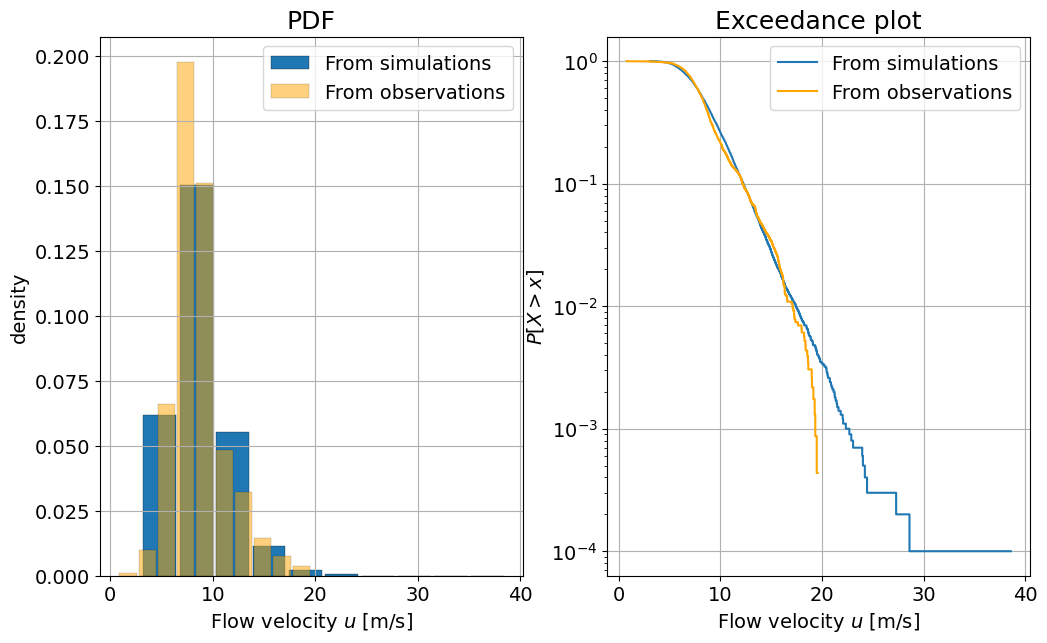

In [12]:
# Here, the solution is shown for the Lognormal distribution

# Draw random samples
rs_h = stats.lognorm.rvs(*params_h, size = 10000)
rs_q = stats.gumbel_r.rvs(*params_q, size = 10000)

# Compute u
rs_u = rs_q / rs_h / 95

# Repeat for observations
u = q / h / 95

# Plot the PDF and the CDF
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].hist(rs_q, edgecolor='k', linewidth=0.2, density = True, label = 'From simulations', bins = 10, rwidth = 0.9)
axes[0].hist(q, edgecolor='k', facecolor = 'orange', alpha = 0.5, linewidth=0.2, bins = 10, rwidth = 0.9,
             density = True, label = 'From observations')
axes[0].set_xlabel('Flow velocity $u$ [m/s]')
axes[0].set_ylabel('density')
axes[0].set_title('PDF', fontsize=18)
axes[0].legend()
axes[0].grid()

axes[1].step(ecdf(rs_q)[1], 1-ecdf(rs_q)[0], label = 'From simulations')
axes[1].step(ecdf(q)[1], 1-ecdf(q)[0], color = 'orange', label = 'From observations')
axes[1].set_xlabel('Flow velocity $u$ [m/s]')
axes[1].set_ylabel('${P[X > x]}$')
axes[1].set_title('Exceedance plot', fontsize=18)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid()

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 8:</b>  
 
Interpret the figures above, answering the following questions:
- Are there differences between the two computed distributions for $q$?</li>
- What are the advantages and disadvantages of using the simulations?</li>
</p>
</div>

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>

- In the PDF plot, we can see that the shape of the distribution is similar for $u$. In the CDF plot, we can see that there are significant differences in the tail of the distribution of $u$. Specifically, the values from the observations are lower than those computed from the simulations. This is because the both distributions overestimated the exceedance probability in the right tails, also leading to larger predictions of the flow velocity.
- <b>Disadvantages:</b> we are assuming that $h$ and $q$ are independent (we will see how to address this issue next week). But is that true? Also, the results are conditioned to how good model is the selected parametric distribution. In this case, since the tail of the distribution of $h$ is not properly fitted, the obtained distribution for $u$ deviates from the one obtained from the observations.
- <b>Advantages:</b> I can draw all the samples I want allowing the computation of events I have not observed yet (extreme events).
</div>

If you run the code in the cell below, you will obtain a scatter plot of both variables. Explore the relationship between both variables and answer the following questions:

<div style="background-color:#AABAB2; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
<p>
<b>Task 9:</b>   
    
1. Observe the plot below. What differences do you observe between the generated samples and the observations?
    
2. What can you improve the previous analyses? Do you have any ideas/suggestions on how to implement those suggestions?
</p>
</div>

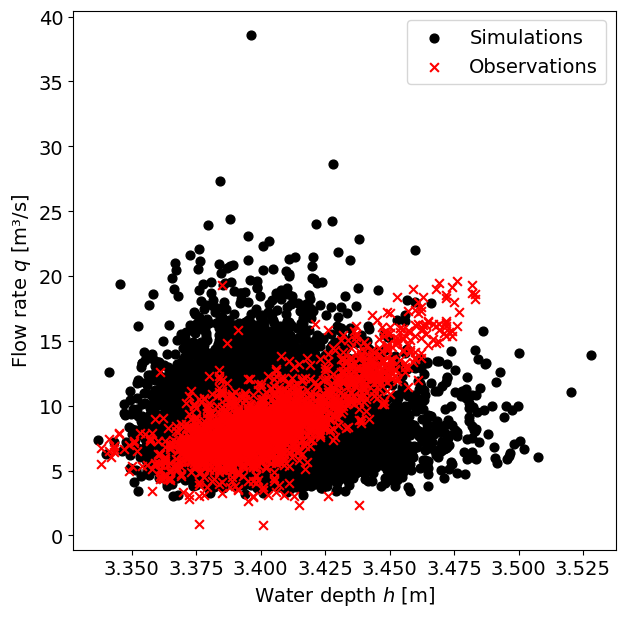

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
axes.scatter(rs_h, rs_q, 40, 'k', label = 'Simulations')
axes.scatter(h, q, 40, 'r', marker = 'x', label = 'Observations')
axes.set_xlabel('Water depth $h$ [m]')
axes.set_ylabel('Flow rate $q$ [m³/s]')
axes.legend()
axes.grid
plt.savefig("scatterplot.png",dpi=300)

<div style="background-color:#FAE99E; color: black; width:95%; vertical-align: middle; padding:15px; margin: 10px; border-radius: 10px">
    <b>Solution:</b>

- The observations along a narrow drop-shaped area of the plot, whereas the simulations are spread all around. This is because the observations are dependent, since there is a physical relationship between the water depth and the velocity of the flow, while the simulations were assumed to be independent.
- <b>Some suggestions:</b> Improve the fit in the tail for $h$ and $q$. Account for the dependence between the two variables.
</div>

> By Max Ramgraber, Patricia Mares Nasarre and Robert Lanzafame, Delft University of Technology. CC BY 4.0, more info [on the Credits page of Workbook](https://mude.citg.tudelft.nl/workbook-2025/credits.html).